In [1]:
import pandas as pd
import numpy as np
import pylab as plt

import mysql.connector

pd.options.mode.chained_assignment = None

mydb = mysql.connector.connect(
  host="172.28.200.50",
  user="root",
  port=3306,
  passwd="insert-password-here",
  database="iiwari_org")

mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT * FROM SensorData;" );

df = pd.DataFrame(mycursor.fetchall())
df.head()

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Plot miltä näyttää x ja y koordinaatit

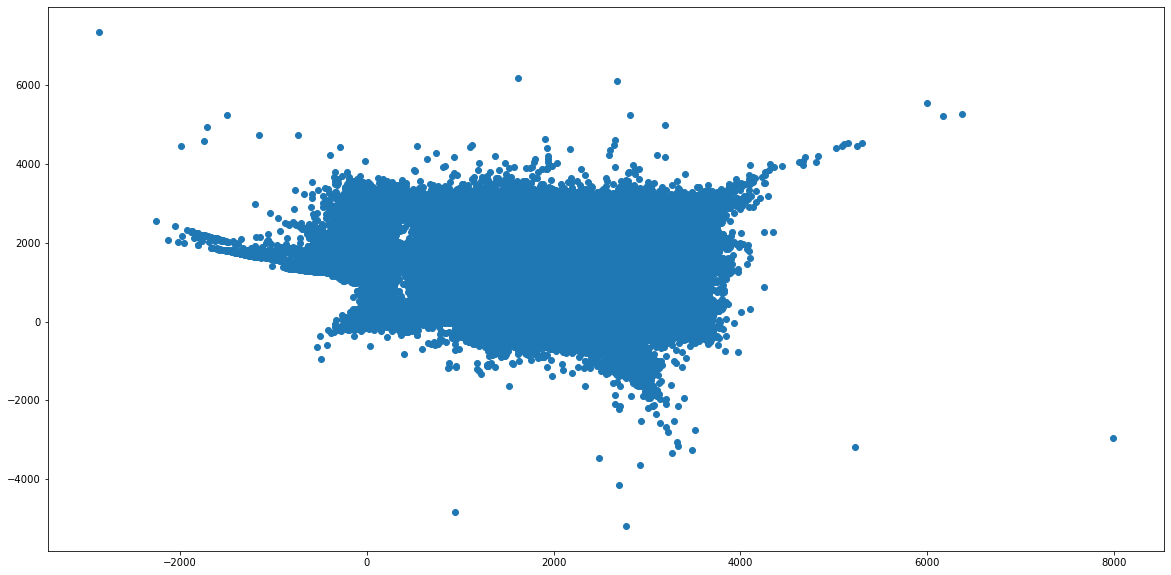

In [2]:
plt.rcParams['figure.figsize'] = [20,10]
plt.plot(df.x[:1000000], df.y[:1000000], 'o')

# Zscorella suurimmat hypyt pois

In [3]:
from scipy.stats import zscore
from scipy import stats
df1 = df[['x','y']].copy()

z_scores = stats.zscore(df1)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
new_df = df[filtered_entries]
new_df


,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0
...,...,...,...,...,...,...
13890901,b'4996252679627069957',b'2020-06-01 03:00:05.469336+00:00',635,1064,0,0
13890902,b'4996252679627069957',b'2020-06-01 03:00:06.47926+00:00',681,760,0,0
13890903,b'4996252679627069957',b'2020-06-01 03:00:08.507118+00:00',622,991,0,0
13890904,b'4996252679627069957',b'2020-06-01 03:00:09.547553+00:00',644,1066,0,0


# Laitetaan timestamp datetime muotoon ja korjataan timezonet

In [9]:
# Leikataan erikoismerkit pois
new_df['timestamp'] = new_df['timestamp'].astype(str)
new_df['timestamp'] = new_df['timestamp'].str.slice(2, -7)
new_df['timestamp'] = new_df['timestamp'].astype('datetime64[ns]')

 # Pyöristys millisekuntien tarkkuudelle
new_df.timestamp = new_df.timestamp.dt.round("ms")


    # Muunnetaan Suomen aikaan. Tämä huomioi kesä- ja talviajan.
new_df.timestamp = new_df.timestamp.dt.tz_localize('UTC')
new_df.timestamp = new_df.timestamp.dt.tz_convert('Europe/Helsinki')

new_df

# Poistetaan dublikaatit node_id ja timestampin mukaan

In [5]:
new_df = new_df.drop_duplicates(subset=['node_id','timestamp'], keep='first')

# Node_id:t järkevään muotoon

In [10]:
new_df['node_id'] = pd.factorize(new_df['node_id'])[0] + 1
new_df

# Tallennetaan uusi dataframe .csv tiedostoon

In [7]:
new_df.to_csv('./data/clean_data.csv',index=False)